# Stroke Prediction using RandomForestClassifier with ibm-watson-machine-learning

### Section 1: Create and Publish Model to Deployment Space on IBM Watson studio

## 1. Load, Clean, and Visualize

In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install joblib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os, types
from botocore.client import Config
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.drop(columns=['id'],inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [5]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
data.bmi.replace(to_replace=np.nan, value=data.bmi.mean(),inplace=True)

In [7]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [8]:
all_columns = list(data.columns)
categorical_data_cols  = [column for column in all_columns if len(data[column].unique())<=5]
continuous_data_cols  = [column for column in all_columns if column not in categorical_data_cols]

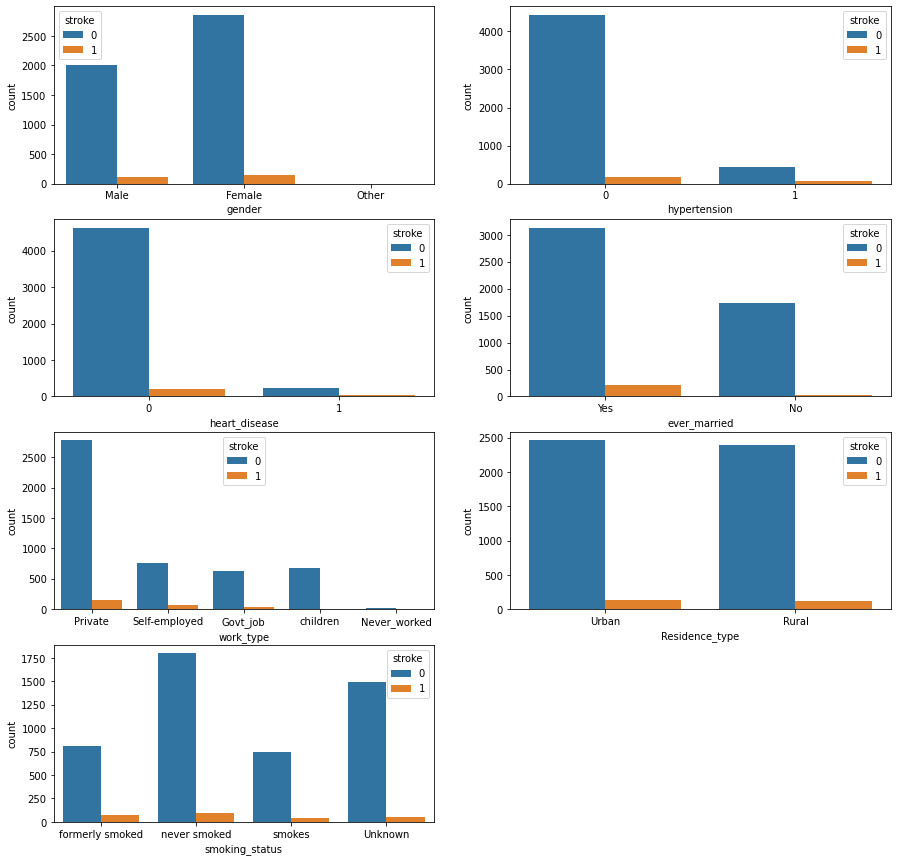

In [9]:
plt.figure(figsize = (15,15))
i = 1
for column in categorical_data_cols[:-1]:
    plt.subplot(4, 2, i)
    sns.countplot(x = data[column], hue = data["stroke"])
    i+=1
plt.show()

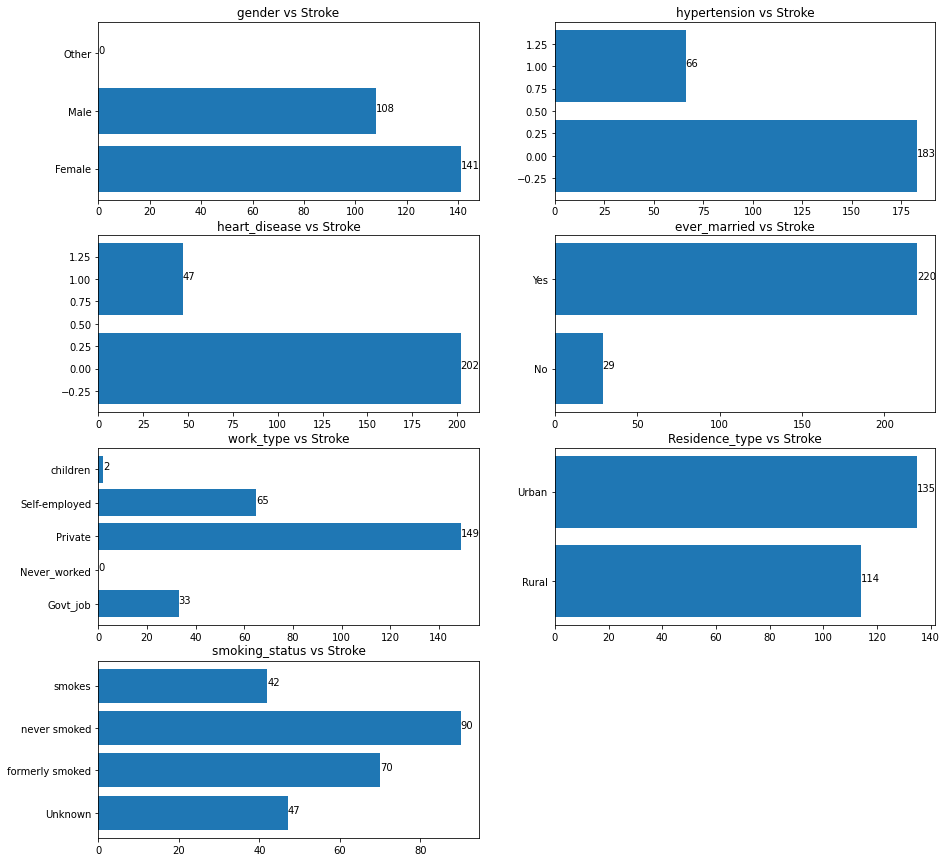

In [10]:
plt.figure(figsize = (15,15))
i = 1
for column in categorical_data_cols[:-1]:
    type_count = data.groupby(column)["stroke"].sum()
    plt.subplot(4, 2, i)
    x = type_count.index
    y = type_count.values
    plt.barh(x, y)
    plt.title(f"{column} vs Stroke")
    for index, value in enumerate(y):
        plt.text(value, index,
                 value)
    i+=1
plt.show()

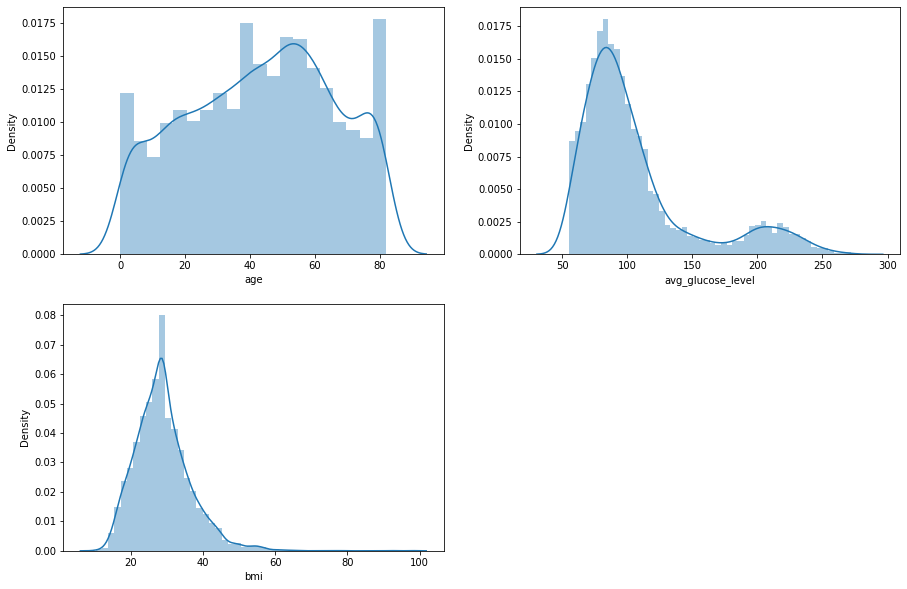

In [11]:
plt.figure(figsize = (15, 10))
i = 1
for column in continuous_data_cols:
    plt.subplot(2, 2, i)
    sns.distplot(data[column])
    i+=1
plt.show()

<Figure size 1080x1080 with 0 Axes>

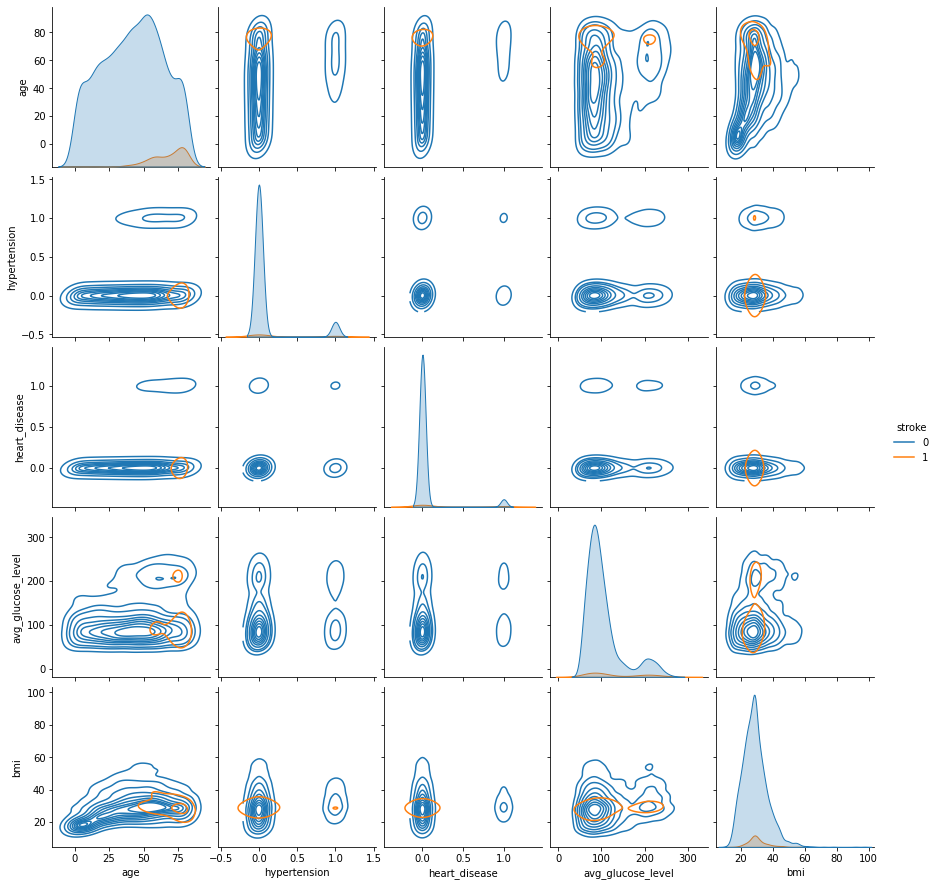

In [12]:
plt.figure(figsize=(15,15))
sns.pairplot(data[['gender','age','hypertension','heart_disease','avg_glucose_level','bmi','stroke']],hue='stroke',kind='kde')
plt.show()

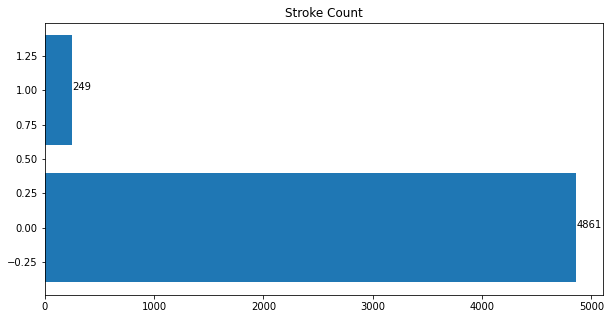

In [13]:
plt.figure(figsize = (10,5))
stroke_count = data["stroke"].value_counts()
x = stroke_count.index
y = stroke_count.values
plt.barh(x,y)
for index, value in enumerate(y):
        plt.text(value, index,
                 value)

plt.title(f"Stroke Count")
plt.show()

## 2. Train and Build Model/Pipeline

In [ ]:
!pip install scikit-learn==0.23
!pip install xgboost==0.90
!pip install imbalanced-learn==0.7.0

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
data = data[data['smoking_status']!='Unknown']

In [16]:
# gender
le = LabelEncoder()
le.fit(data.gender.drop_duplicates())
data.gender = le.transform(data.gender)

# residence type
le.fit(data.Residence_type.drop_duplicates())
data.Residence_type = le.transform(data.Residence_type)

# ever married
le.fit(data.ever_married.drop_duplicates())
data.ever_married = le.transform(data.ever_married)

# smoking status
le.fit(data.smoking_status.drop_duplicates())
data.smoking_status = le.transform(data.smoking_status)

# work type
le.fit(data.work_type.drop_duplicates())
data.work_type = le.transform(data.work_type)

In [17]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,0,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,1,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,1,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,2,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,1,1


In [18]:
x = data.drop(["stroke"] , axis = 1)
y = data["stroke"]

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x, y)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=0)

In [22]:
pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', RandomForestClassifier(random_state = 0))])

In [23]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('data_scaling', StandardScaler()),
                ('model', RandomForestClassifier(random_state=0))])

In [24]:
joblib.dump(pipeline, 'stroke_pipeline.pkl')

['stroke_pipeline.pkl']

In [25]:
model = joblib.load('stroke_pipeline.pkl')

In [26]:
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
accuracies = cross_val_score(estimator = model, X = x_train , y = y_train, cv = KFold(n_splits=10, random_state=2020, shuffle=True), scoring = "accuracy")
kfold = accuracies.mean()*100
stdd = accuracies.std()*100
roc_auc = roc_auc_score(y_test, y_pred)

print("Random Forest Classifier Reports:")
print(cm)
print(cr)
print('K-Fold Validation Mean Accuracy: {}'.format(kfold))
print('Standard Deviation: {}'.format(stdd))
print('ROC AUC Score: {}'.format(roc_auc))
print("---"*20)

Random Forest Classifier Reports:
[[601  67]
 [ 34 644]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       668
           1       0.91      0.95      0.93       678

    accuracy                           0.92      1346
   macro avg       0.93      0.92      0.92      1346
weighted avg       0.93      0.92      0.92      1346

K-Fold Validation Mean Accuracy: 93.23699402031849
Standard Deviation: 1.3697089113422924
ROC AUC Score: 0.9247765530885131
------------------------------------------------------------


In [27]:
values = np.array([[1, 22.0, 1, 1, 1, 0, 0, 200.0, 30.0, 0]])
predict = model.predict(values)
print(predict)

[0]


## 3. Connection to IBM Watson Machine Learning

In [ ]:
api_key = 'YOUR-API-KEY'
location = 'YOUR-LOCATION'

In [ ]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

In [ ]:
!pip install -U ibm-watson-machine-learning

In [ ]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)
print(client.version)

In [ ]:
space_id = 'YOUR-SPACE-ID'

In [ ]:
client.spaces.list(limit=10)

In [ ]:
client.set.default_space(space_id)

## 4. Publish Model

In [ ]:
base_sw_spec_uid = client.software_specifications.get_id_by_name("default_py3.7")

In [ ]:
!pip install wget

In [29]:
import wget

url = 'https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/configs/config.yaml'
if not os.path.isfile('config.yaml'):
    wget.download(url)

In [ ]:
meta_prop_pkg_extn = {
    client.package_extensions.ConfigurationMetaNames.NAME: "scikt with autoai-libs",
    client.package_extensions.ConfigurationMetaNames.DESCRIPTION: "Extension for autoai-libs",
    client.package_extensions.ConfigurationMetaNames.TYPE: "conda_yml"
}

pkg_extn_details = client.package_extensions.store(meta_props=meta_prop_pkg_extn, file_path="config.yaml")
pkg_extn_uid = client.package_extensions.get_uid(pkg_extn_details)
pkg_extn_url = client.package_extensions.get_href(pkg_extn_details)

In [ ]:
meta_prop_sw_spec = {
    client.software_specifications.ConfigurationMetaNames.NAME: "Mitigated AutoAI bases on scikit spec",
    client.software_specifications.ConfigurationMetaNames.DESCRIPTION: "Software specification for scikt with autoai-libs",
    client.software_specifications.ConfigurationMetaNames.BASE_SOFTWARE_SPECIFICATION: {"guid": base_sw_spec_uid}
}

sw_spec_details = client.software_specifications.store(meta_props=meta_prop_sw_spec)
sw_spec_uid = client.software_specifications.get_uid(sw_spec_details)

client.software_specifications.add_package_extension(sw_spec_uid, pkg_extn_uid)

In [ ]:
client.software_specifications.get_details(sw_spec_uid)

In [ ]:
input_data_schema = {'id': '1',
                'fields': [{'name': 'gender', 'type': 'float'},
                            {'name': 'age', 'type': 'float'},
                            {'name': 'hypertension', 'type': 'float'},
                            {'name': 'heart_disease', 'type': 'float'},
                            {'name': 'ever_married', 'type': 'float'},
                            {'name': 'work_type', 'type': 'float'},
                            {'name': 'Residence_type', 'type': 'float'},
                            {'name': 'avg_glucose_level', 'type': 'float'},
                            {'name': 'bmi', 'type': 'float'},
                            {'name': 'smoking_status', 'type': 'float'}]}

In [ ]:
model_props = {
    client.repository.ModelMetaNames.NAME: "Stroke Prediction Model - AutoAI",
    client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
    client.repository.ModelMetaNames.INPUT_DATA_SCHEMA: input_data_schema,
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid
    
}
feature_vector = x.columns

In [ ]:
published_model = client.repository.store_model(
    model=model, 
    meta_props=model_props,
    training_data=x.values,
    training_target=y.values,
    feature_names=feature_vector,
    label_column_names=['stroke']
)

In [ ]:
published_model_uid = client.repository.get_model_id(published_model)

In [ ]:
client.repository.get_details(published_model_uid)

In [ ]:
client.repository.list_models()

## 5. Create Batch Deployment

In [ ]:
meta_data = {
    client.deployments.ConfigurationMetaNames.NAME: "Batch Deployment for Stroke Prediction Model - AutoAI",
    client.deployments.ConfigurationMetaNames.BATCH: {},
    client.deployments.ConfigurationMetaNames.HARDWARE_SPEC: {"name": "S", "num_nodes": 1}

}
deployment_details = client.deployments.create(published_model_uid, meta_props=meta_data)

In [ ]:
deployment_uid = client.deployments.get_uid(deployment_details)

In [ ]:
client.deployments.list()

In [ ]:
client.deployments.get_details(deployment_uid)